<a href="https://colab.research.google.com/github/fullbread9977/Titanic-bagging_ensemble_RandomForest-/blob/main/211115_%5BHyperparameter%20Optimization%5Dbagging_ensemble_RandomForest_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


파일을 읽어오기 위해 구글 드라이브를 연결한다

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

필요한 라이브러리를 불러온다

사용한 파일: [다운로드 링크](https://www.kaggle.com/ash316/eda-to-prediction-dietanic/data?select=train.csv)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/titanic/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


파일을 다운로드 한 것을 내드라이브 경로로 설정 후 데이터의 상단부분만 불러온다

# 데이터 전처리

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


데이터의 타입을 보기 위해 data.info()를 입력

- PassengerID : 아마도 행렬번호
- Suervived : 생존여부
 >targer label 1,0으로 표현 
- Pclass : 티켓의 클래스
>1 = 1st    
2 = 2nd    
3 = 3rd   
클래스로 나뉨 
- sex : 성별
> male, female로 구분 
- Age: 나이
- sibSp : 함께 탑승한 형제와 배우자의 수
- parch : 함께 탑승한 부모, 아이의 수
- ticket : 티켓번호 
> 알파벳 + 숫자
- fare : 탑승료
- cabin : 객실번호
> 알파벳 + 숫자
- embared : 탑승항구
> C = Cherbourg,    
Q = Queenstown,    
S= Southampton


In [ ]:
data['Embarked'].fillna('S', inplace = True)
data['Fare'].fillna(0, inplace=True)
data['Fare'] = data['Fare'].map(lambda x : np.log(x) if x > 0 else 0)

- 데이터프레임의 탑승항구(Embarked) 행의 결측값을 S으로 할당한다
- 데이터프레임의 요금(Fare)행의 결측값을 0으로 할당한다




In [ ]:
data['Initial'] = data['Name'].str.extract('([A-Za-z]+)\.')
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Other'],inplace=True)
mapping = {
    "Mr":0,
    "Miss":1,
    "Mrs" : 1,
    "Master":2,
    "Other":3
}

data['Initial'] = data['Initial'].map(mapping)

Initial행을 만들어 탑승자의 신분과 성별 호칭으로 구분하여    
남자 Mr 0,         
여자(미혼) Miss 1,     
여자(기혼) Mrs 1,      
아이 Master 2,    
그 밖의 사람들 Other 3    
으로 구분하여 행을 새로 만든다.


In [ ]:
mapping_sex = {
    'male' : 0,
    'female': 1
}

mapping_em = {
    'S' :0,
    'C' :1,
    'Q' :2
}


data['Sex'] = data['Sex'].map(mapping_sex)
data['Embarked'] = data['Embarked'].map(mapping_em)


data.drop(['PassengerId', "Ticket", "Cabin", "Name"], axis = 1, inplace = True)

성별은 남자는 0, 여자는1     
탑승항구 S는 0, C는 1, Q는 2 로 값을 대체하고    
PassengerId, Ticket, Cabin , Name을 데이터 프레임에서 제외한다

In [ ]:
data.groupby('Initial')['Age'].mean()

Initial
0    32.739609
1    27.834615
2     4.574167
3    45.888889
Name: Age, dtype: float64

데이터의 Initial 값으로 나이 테이블을 묶어 평균을 낸다     


In [ ]:
data.loc[ (data['Age'].isnull()) & (data['Initial'] == 0), 'Age' ] = 32
data.loc[ (data['Age'].isnull()) & (data['Initial'] == 1), 'Age' ] = 28
data.loc[ (data['Age'].isnull()) & (data['Initial'] == 2), 'Age' ] = 5
data.loc[ (data['Age'].isnull()) & (data['Initial'] == 3), 'Age' ] = 45

Age 데이터의 결측값을 평균으로 대체하여 넣는다    
남자의 경우엔 32,    
여자의 경우엔 28,   
아이의 경우엔 5     
중년의 경우엔 45로 결측값을 대체한다.

In [ ]:

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Initial
0,0,3,0,22.0,1,0,1.981001,0,0
1,1,1,1,38.0,1,0,4.266662,1,1
2,1,3,1,26.0,0,0,2.070022,0,1
3,1,1,1,35.0,1,0,3.972177,0,1
4,0,3,0,35.0,0,0,2.085672,0,0


# 학습데이터 시험데이터 구분

제대로 데이터가 바꼈는지 보기위해 상위 데이터를 불러온다

In [ ]:
y = data['Survived']
X = data.drop('Survived', axis = 1)

X의 데이터에는 생존여부를 제외한 데이터들, 
y의 데이터에는 생존 데이터를 넣는다.

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X과 y의 학습과 시험데이터를 8:2로 나눠 랜덤방법은 42의 방식으로 데이터를 무작위로 집어넣는다

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

랜덤포레스트 모델을 불러와 학습데이터들을 모델에 넣는다.     
부트스트랩을 사용하고,불평등지수는 지니계수를 사용하며, 최대가지 수는 자동,      
제일작은 잎의 숫자는 1,가지 수는 2로 분열한다. 100번 반복하여 모델을 돌린다.

In [ ]:
pred = rf.predict(X_test)
print("정확도 :{0:.3f}".format(accuracy_score(y_test, pred)))

정확도 :0.844


정확도는 84.4%

In [ ]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

그래디언트 부스팅 모델을 불러온다.     
모델에 학습데이터를 불러와 학습시킨다.       
데이터 랜덤 배분 방식은 42으로 설정한다.     
최대 나무가지 수는 3, 최소 잎의 수는 1, 최소 나뭇가지 수는 2로     
100번 반복하여 학습시킨다.




건드린 설정     
random_state = 0 -> random_state=42     
인터넷에서 찾은 코드들이 42방식으로 사용되는 코드들이 있었기에 42로 수정했다

In [ ]:
pred = gb.predict(X_test)
print("정확도 :{0:.3f}".format(accuracy_score(y_test, pred)))

정확도 :0.832


정확도는 83.2%

# 최적화하기

In [ ]:
gb_param_grid = {
    'n_estimators' : [10,25,50, 100, 200],
    'max_depth' : [8,10,12,18],
    'min_samples_leaf' : [3, 5, 7, 10, 12, 18 ],
    'min_samples_split' : [2, 3, 5, 10, 12,16, 20],
    'learning_rate' : [0.05, 0.1, 0.2]
}

그라디언트 부스팅 모델의 설정을    
학습 반복 횟수는 10,25,50,100번, 200번    
최대 나뭇가지 수는  8, 10, 12, 18    
최소 잎의 수는 3, 5, 7, 10, 12, 18   
최대 잎의 수는 2, 3, 5, 10, 12,  16, 20    
학습률을  0.05, 0.1, 0.2     
에서 가장 최적한 값으로 가장 높은 정확도의 모델을 찾는다.


In [ ]:
gb_grid = GridSearchCV(gb, param_grid = gb_param_grid, scoring="accuracy", n_jobs= -1, verbose = 1)
gb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 11246 tasks      |

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n...
                 

최적화 값을 찾기 위해 모델과 최적방법, 정확도가 쓰여진 학습하는 과정을 본다.    
학습데이터를 불러와 학습한다.

In [ ]:
print("최고 평균 정확도 : {0:.4f}".format(gb_grid.best_score_))
print("최고의 파라미터 : ", gb_grid.best_params_)

최고 평균 정확도 : 0.8371
최고의 파라미터 :  {'learning_rate': 0.2, 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}


최고 평균 정확도는 84.27%이고,
최적의 값은 학습률 비율은 0.1, 최대 나뭇가지 수는 16, 최소잎의 수는 10, 최소 나무가지수는 2, 반복학습 횟수는 25번이 가장 최적화 된 설정이다.

결과를 csv 파일 utf-8 형식으로 저장한다
- 파일 경로를 지정하지 않을 시 drive의 상위폴더인 content에 파일이 저장된다.


In [ ]:
result = pd.DataFrame(gb_grid.cv_results_)
result.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

최적화의 최종결과값을 데이터 프레임으로 만들어 컬럼값을 불러온다.

In [ ]:
result.sort_values(by=['rank_test_score'], inplace=True)

In [ ]:
result.to_csv("/content/drive/MyDrive/titanic/grap_result.csv", encoding="utf-8")

그 중 rank_test_socre 에 소트값을 매겨 순위를 세운다. 

In [ ]:
result[['params', 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
2165,"{'learning_rate': 0.2, 'max_depth': 12, 'min_s...",0.837083,1
1116,"{'learning_rate': 0.1, 'max_depth': 10, 'min_s...",0.837073,2
487,"{'learning_rate': 0.05, 'max_depth': 12, 'min_...",0.835694,3
266,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",0.834276,4
57,"{'learning_rate': 0.05, 'max_depth': 8, 'min_s...",0.834256,5
1745,"{'learning_rate': 0.2, 'max_depth': 8, 'min_sa...",0.832877,6
2375,"{'learning_rate': 0.2, 'max_depth': 18, 'min_s...",0.832877,6
896,"{'learning_rate': 0.1, 'max_depth': 8, 'min_sa...",0.832877,6
446,"{'learning_rate': 0.05, 'max_depth': 12, 'min_...",0.832867,9
1715,"{'learning_rate': 0.2, 'max_depth': 8, 'min_sa...",0.832867,9


가장 좋은 최적값의 순위 10개를 불러온다

In [ ]:
model = gb_grid.best_estimator_
pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
print("정확도 : {0:.4f}".format(acc))

정확도 : 0.8659


최적화한 모델의 제일 좋은 모델의 값을 불러와    
시험데이터를 넣고 학습하고 정확도를 본다    
정확도는 86.59% 가 나왔다

In [ ]:
 feature_importances = model.feature_importances_

결과값(생존)에 순위를 준 인자들을 보기 위해 컬럼값을 불러온다

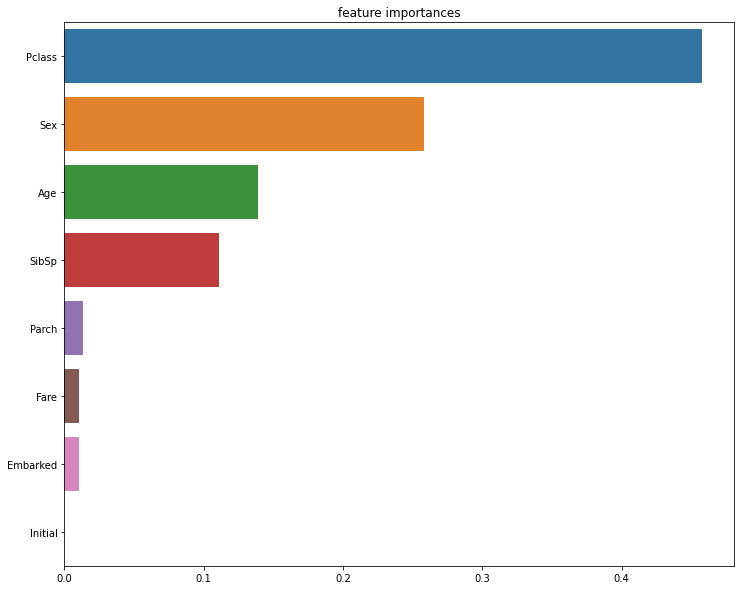

In [ ]:
ft_importances = pd.Series(feature_importances, index = X_train.columns)
ft_importances = ft_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y = X_train.columns)
plt.show()

생존에 영향을 미친 1위는 클래스 등급, 2위는 성별, 3위는 나이, 4위는 함께 탑승한 형제/배우자의 수가 연관성이 많은 것으로 보인다.

# 최적화 모델적용

In [ ]:
import pandas as pd
import numpy as np

grid_data = pd.read_csv('/content/drive/MyDrive/titanic/grap_result.csv')

mean과 best값이 차이가 많이 나기에 파일을 보기 위해 저장한 grap_result를 불러온다



In [ ]:
grid_data.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2165,0.044341,0.002345,0.002227,0.000056,0.20,12,5,20,10,"{'learning_rate': 0.2, 'max_depth': 12, 'min_s...",0.839161,0.832168,0.838028,0.852113,0.823944,0.837083,0.009251,1
1,1116,0.103241,0.005770,0.002330,0.000052,0.10,10,5,20,25,"{'learning_rate': 0.1, 'max_depth': 10, 'min_s...",0.839161,0.839161,0.823944,0.859155,0.823944,0.837073,0.012970,2
2,487,0.214950,0.003218,0.002745,0.000260,0.05,12,5,20,50,"{'learning_rate': 0.05, 'max_depth': 12, 'min_...",0.832168,0.825175,0.838028,0.859155,0.823944,0.835694,0.012783,3
3,266,0.126335,0.005301,0.002492,0.000086,0.05,10,5,12,25,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",0.818182,0.846154,0.838028,0.830986,0.838028,0.834276,0.009371,4
4,57,0.211298,0.004918,0.003182,0.001029,0.05,8,5,12,50,"{'learning_rate': 0.05, 'max_depth': 8, 'min_s...",0.839161,0.839161,0.823944,0.845070,0.823944,0.834256,0.008692,5


정상적으로 불러와졌는지 상위데이터보기

In [ ]:
grid_data.sort_values(by=['rank_test_score'], inplace=True)

순위를 매겨 파일을 불러온다

In [ ]:
grid_data.head(10)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2165,0.044341,0.002345,0.002227,0.000056,0.20,12,5,20,10,"{'learning_rate': 0.2, 'max_depth': 12, 'min_s...",0.839161,0.832168,0.838028,0.852113,0.823944,0.837083,0.009251,1
1,1116,0.103241,0.005770,0.002330,0.000052,0.10,10,5,20,25,"{'learning_rate': 0.1, 'max_depth': 10, 'min_s...",0.839161,0.839161,0.823944,0.859155,0.823944,0.837073,0.012970,2
2,487,0.214950,0.003218,0.002745,0.000260,0.05,12,5,20,50,"{'learning_rate': 0.05, 'max_depth': 12, 'min_...",0.832168,0.825175,0.838028,0.859155,0.823944,0.835694,0.012783,3
3,266,0.126335,0.005301,0.002492,0.000086,0.05,10,5,12,25,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",0.818182,0.846154,0.838028,0.830986,0.838028,0.834276,0.009371,4
4,57,0.211298,0.004918,0.003182,0.001029,0.05,8,5,12,50,"{'learning_rate': 0.05, 'max_depth': 8, 'min_s...",0.839161,0.839161,0.823944,0.845070,0.823944,0.834256,0.008692,5
5,1745,0.039061,0.001949,0.002108,0.000030,0.20,8,5,20,10,"{'learning_rate': 0.2, 'max_depth': 8, 'min_sa...",0.832168,0.825175,0.845070,0.830986,0.830986,0.832877,0.006567,6
6,2375,0.046207,0.000651,0.002210,0.000084,0.20,18,5,20,10,"{'learning_rate': 0.2, 'max_depth': 18, 'min_s...",0.832168,0.825175,0.838028,0.852113,0.816901,0.832877,0.011930,6
7,896,0.110160,0.008118,0.002736,0.000341,0.10,8,5,12,25,"{'learning_rate': 0.1, 'max_depth': 8, 'min_sa...",0.825175,0.832168,0.823944,0.859155,0.823944,0.832877,0.013490,6
12,1730,0.046059,0.001050,0.002240,0.000173,0.20,8,5,10,10,"{'learning_rate': 0.2, 'max_depth': 8, 'min_sa...",0.825175,0.839161,0.830986,0.852113,0.816901,0.832867,0.012063,9
11,1725,0.046859,0.002556,0.003796,0.002871,0.20,8,5,5,10,"{'learning_rate': 0.2, 'max_depth': 8, 'min_sa...",0.825175,0.839161,0.830986,0.852113,0.816901,0.832867,0.012063,9


1위는 정확도가 83아래로 떨어지지 않았고 가장높은 값이 85.21%,               
2위는 정확도가 세번 째에서 82로 떨어졌고 가장높은 값이 85.91%으로 2위로 판정되었다

In [ ]:
rf = RandomForestClassifier(max_depth= 12, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 10,random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

1위 모델의 값을 가져와 입력한다    
'learning_rate=0.1'는 결정할 수 없는 걸로 보여 설정에서 제외됬다 

- {'learning_rate': 0.2, 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}

In [ ]:
pred = rf.predict(X_test)
print("정확도 :{0:.4f}".format(accuracy_score(y_test, pred)))

정확도 :0.8212


1위 모델의 정확도는 82.12% 다

In [ ]:
rf = RandomForestClassifier(max_depth= 10, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 25,random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

2위 모델의 값을 가져온다
- {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 25}"

In [ ]:
pred = rf.predict(X_test)
print("정확도 :{0:.4f}".format(accuracy_score(y_test, pred)))

정확도 :0.8268


정확도는 82.68로 나왔다

가장높은 값은 86.61 1956으로,평균이 82.02로 순위가 430번 째였다

 - 오류    
 'n_estimators'는 중복되어 들어가서 오류난 것이었다.